## Chromaffin dataset - eco-velo

**In this Notebook we will be applying eco-velo on the chromaffin dataset. This dataset was originally published by Furlan et al. (https://doi.org/10.1126/science.aal3753). The dataset was used for RNA velocity for the first time by La Manno et al. (https://doi.org/10.1038/s41586-018-0414-6). This dataset was generated using SMART-seq2 and shows mouse Schwann cell precursors (SCPs) differentiating into chromaffin cells.** 

In [1]:
### load libraries

# general libraries
import pandas as pd
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree #used for smooting

# other
import sklearn as sk #used for L2 normalization

# import our own functions
from velocity.processing.filtering import *
from velocity.processing.imputation import *
from velocity.processing.normalisation import *

from velocity.tools.filtering import *
from velocity.tools.fit import *
from velocity.tools.eco_velo import *

from velocity.visualisation.vis import *
from velocity.visualisation.pretty_plotting import *

### Load dataset
Here, we load the spliced and unspliced matrices from the original dataset, as well as the original clusters, colours and t-SNE embedding. All of the files used here can be downloaded from this webpage: http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html (a tutorial on velocyto provided by La Manno and the Karchenko lab). The original file name is `onefilepercell_A1_unique_and_others_J2CH1.loom `, which we renamed to `chromaffin.loom`. The files with the cell colors/clusters (`cell_colors.csv`) and the t-SNE embedding (`embedding.csv`) can be found on this GitHub page under datasets/chromaffin.

In [2]:
### load chromaffin dataset
chromaffin_path = "../datasets/chromaffin/chromaffin.loom"
adata = ad.read_loom(chromaffin_path)

In [3]:
### make obs names shorter
new_names = []

for obs_name_idx in range(len(adata.obs_names)):
    obs_name = adata.obs_names[obs_name_idx]
    new_name = obs_name.replace("onefilepercell_A1_unique_and_others_J2CH1:", "")
    new_name = new_name.replace("_unique.bam", "")
    new_names.append(new_name)

adata.obs_names = new_names

In [4]:
### add clusters from original publication
clusters_path ="../datasets/chromaffin/cell_colors.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
adata = adata[clusters.index,:]
adata.obs["clusters"] = clusters

Trying to set attribute `.obs` of view, copying.


In [5]:
### set correct names and colours to clusters
cluster_names = {'#00FF66FF':'0','#0066FFFF':'1','#CC00FFFF':'2','#CCFF00FF':'3','#FF0000FF':'4'}
adata.obs['clusters'] = (adata.obs['clusters'].map(cluster_names).astype('category'))
adata.uns['clusters_colors'] = ['#00FF66FF','#0066FFFF','#CC00FFFF','#CCFF00FF','#FF0000FF']

In [6]:
### add embedding from original publication
embedding_path = "../datasets/chromaffin/embedding.csv"
embedding = pd.read_csv(embedding_path, index_col=0)
adata = adata[embedding.index,:]
adata.obsm["X_tsne"] = embedding
adata.obsm["X_tsne"] = np.array(adata.obsm["X_tsne"])

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


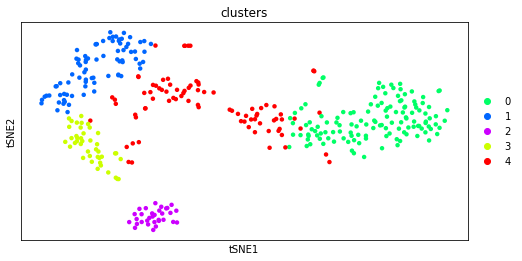

In [7]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(8, 4), frameon=False)
sc.pl.tsne(adata, color="clusters", s=80, ax=axs)

In [8]:
adata

AnnData object with n_obs × n_vars = 369 × 23420
    obs: 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

### Processing
Here, we will process the dataset according to the eco-velo processing workflow. We will select the highly variable genes (HVGs), filter for genes with sufficient unspliced an spliced counts, log-transform the data and last we L2 normalise the spliced and unspliced separately.

In [9]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [10]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=500, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

Subsetting to top 500 highly-variable genes.


/Users/bbouman/Documents/projects/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


In [11]:
### subset for genes that have high enough U and S counts
minlim = 15
us_genes = get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 474 genes with sufficient S and U counts.


In [12]:
### log transformation of the dataset
adata.X = np.matrix(np.where(adata.X != 0, np.log(adata.X), 0))
adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))

<ipython-input-12-4710026e2083>:2: RuntimeWarning: divide by zero encountered in log
  adata.X = np.matrix(np.where(adata.X != 0, np.log(adata.X), 0))
<ipython-input-12-4710026e2083>:3: RuntimeWarning: divide by zero encountered in log
  adata.layers['spliced'] = np.matrix(np.where(adata.layers['spliced'] != 0, np.log(adata.layers['spliced']), 0))
<ipython-input-12-4710026e2083>:4: RuntimeWarning: divide by zero encountered in log
  adata.layers['unspliced'] = np.matrix(np.where(adata.layers['unspliced'] != 0, np.log(adata.layers['unspliced']), 0))


In [13]:
### L2 normalise spliced and unspliced separately
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')
adata.layers['spliced'] = sk.preprocessing.normalize(adata.layers['spliced'], norm='l2')
adata.layers['unspliced'] = sk.preprocessing.normalize(adata.layers['unspliced'], norm='l2')

In [14]:
### L2 normalise unspliced and spliced together with size vector
#normalise_layers(adata, mode='seperate', norm='L2', total_counts=None)

### Find MNN on gene space
In the eco-velo workflow, for each cell we use its unspliced counts and try to find the top N mutual nearest neighbours (MNNs), defined by their spliced counts. We later use the MNNs to plot the velocities onto the embeddings.

Note: since we try to find an MNN in the first 50 neighbours, it might be that some cells are not assigned to any MNN.

In [15]:
adata

AnnData object with n_obs × n_vars = 369 × 474
    obs: 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

In [16]:
### identify MNNs
k = 30
mnn = find_mutual_nn(adata.layers['unspliced'], adata.layers['spliced'], top_n=5, k = k)
print("Cells without assigned MNN: " + str(np.sum(np.all(mnn==-1, axis=1))) + " out of " + str(len(adata)) + " cells.")

Cells without assigned MNN: 27 out of 369 cells.


### Visualisation

Last, we are going to use the MNNs to create the velocity plots. 

**Calculate UMAP embedding**

In [17]:
### scale data (spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

In [18]:
### run PCA
n_pcs = 10
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

In [19]:
### calculate UMAP
reducer = umap.UMAP(random_state=0, n_neighbors=20, min_dist=0.4, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

**Plot UMAP embedding**

In [20]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
cell_colors=adata.obs["clusters"].map(color_dict)
light_color = np.array([lighten_color(i, .3) for i in cell_colors])

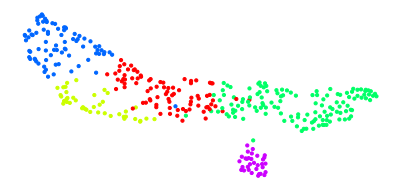

In [21]:
### plot UMAP (just spliced counts)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), frameon=False)
ax.scatter(UMAP_data[:,0], UMAP_data[:,1], s=10, c=cell_colors)
fig.tight_layout()
ax.axis("off")
plt.show()

**Get future states for each cell**

In [22]:
### select MNNs
pos = UMAP_data[mnn]
pos[np.array(mnn)==-1]=np.nan
pos = np.nanmean(pos, axis=1)

<ipython-input-22-c1b3a932b3b1>:4: RuntimeWarning: Mean of empty slice
  pos = np.nanmean(pos, axis=1)


In [23]:
### smoothing; averaging position over nearest neighbours
NN = cKDTree(adata.layers['spliced']).query(x=adata.layers['spliced'], k=30)[1]
pos_mean = np.nanmean(np.array(pos)[NN], axis=1)

**Plot future states in UMAP**

In [24]:
### get points for UMAP
v = np.array(pos) - UMAP_data
v_mean = pos_mean - UMAP_data

In [25]:
kwargs = {"scale": 2, "angles": "xy", "scale_units": "xy", "edgecolors": "k", 
          "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

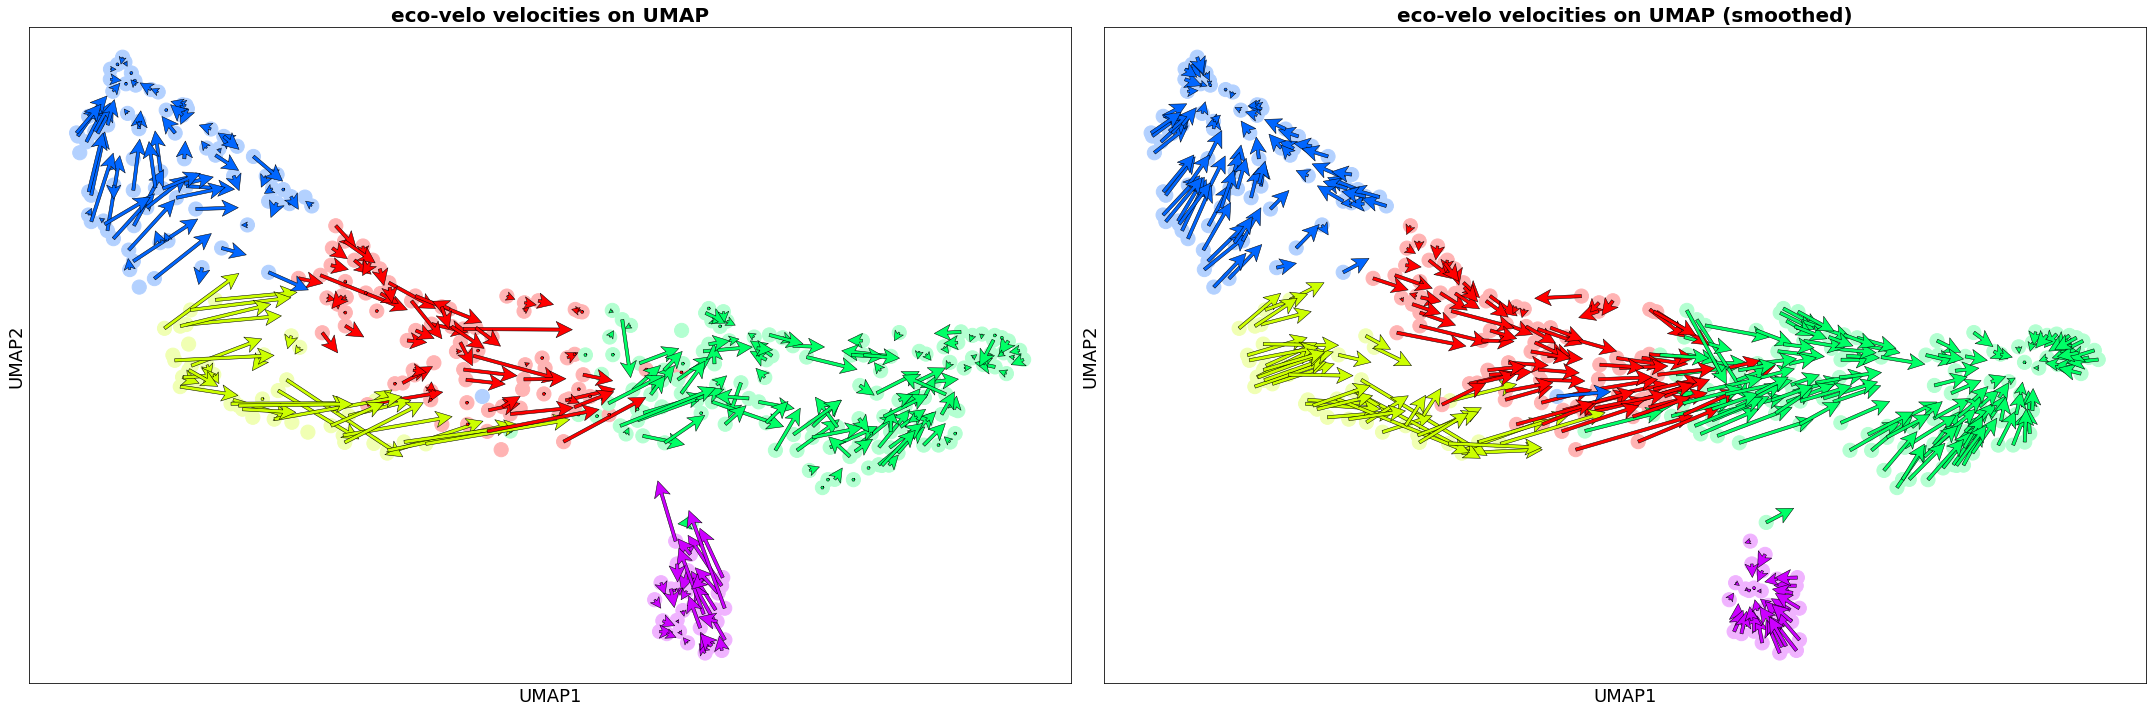

In [26]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)
axs[1].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("UMAP1", fontsize=18)
axs[0].set_ylabel("UMAP2", fontsize=18)
axs[1].set_xlabel("UMAP1", fontsize=18)
axs[1].set_ylabel("UMAP2", fontsize=18)

# title
axs[0].set_title("eco-velo velocities on UMAP", fontsize=20, fontweight="bold")
axs[1].set_title("eco-velo velocities on UMAP (smoothed)", fontsize=20, fontweight="bold")


# plot arrows 
axs[0].quiver(UMAP_data[:,0], UMAP_data[:,1], v[:,0], v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(UMAP_data[:,0], UMAP_data[:,1], v_mean[:,0], v_mean[:,1], color=cell_colors, **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/chromaffin/chromaffin_eco-velo_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()